Drawing the maze as a starter

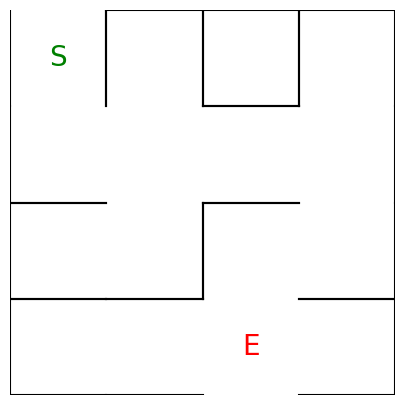

In [2]:
import matplotlib.pyplot as plt
import numpy as np

maze_walls = [
        # (Up, Right, Down, Left) walls for each cell
        [(False, True, False, True), (True, True, False, True), (True, True, True, True), (True, True, False, True)],  # Row 0
        [(False, False, True, True), (False, False, False, False), (True, False, True, False), (False, True, False, False)],  # Row 1
        [(True, False, True, True), (False, True, True, False), (True, False, False, True), (False, True, True, False)],  # Row 2
        [(True, False, True, True), (True, False, True, False), (False, False, False, False), (True, True, True, False)]   # Row 3
    ]


def draw_maze():
    fig, ax = plt.subplots(figsize=(5, 5))

    # Coordinates for the grid (0,0) at the top left, (3,3) at the bottom right
    for i in range(4):
        for j in range(4):
            # Draw cell borders based on wall presence
            if maze_walls[i][j][0]:  # Top wall
                ax.plot([j, j + 1], [4 - i, 4 - i], color='black')
            if maze_walls[i][j][1]:  # Right wall
                ax.plot([j + 1, j + 1], [4 - i - 1, 4 - i], color='black')
            if maze_walls[i][j][2]:  # Bottom wall
                ax.plot([j, j + 1], [4 - i - 1, 4 - i - 1], color='black')
            if maze_walls[i][j][3]:  # Left wall
                ax.plot([j, j], [4 - i - 1, 4 - i], color='black')

    # Mark the start and exit cells
    ax.text(0.5, 3.5, 'S', fontsize=20, ha='center', va='center', color='green')  # Start
    ax.text(2.5, 0.5, 'E', fontsize=20, ha='center', va='center', color='red')    # Exit

    # Set limits and hide ticks
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    # Hide the axes borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Display the maze
    plt.show()

draw_maze()

## 1: Formalizing the Problem as an MDP

**States:** Each cell in the 2D grid is a state. The agent can be in any of these cells, with the start state being (0,0) and the exit state being (3,2). This gives us a total of  4×4=16 states.

**Actions**: The agent can take four actions:

Up
Down
Left
Right

**Transition Probabilities**: Movement is probabilistic. When the agent takes an action:

It moves in the intended direction with probability 0.8.

It moves in the opposite direction or stays in the same cell with probability 0.2, depending on whether the opposite direction is blocked by a wall.

**Rewards**:

+50 for reaching the exit (cell (3,2)).
-10 for colliding with a wall.
-1 for any movement that doesn’t lead to the exit.

**Discount Factor**: γ=0.9.

## 2-3: The objective of penalizing the agent for executing actions

Attempt to move into a wall (no permitted action) or Fail to reach the exit cell (just moving around) will encourage the agent to find an efficient and optimal path to the goal (the exit cell) rather than taking random or unnecessary actions. So it's for avoiding wasteful or random actions (hitting walls), and minimizing the time to reach the goal (reducing unnecessary movements).

## 4-a: Policy Evaluation for π1 and π2

In [25]:
# Define transition actions
transitions = {
    'Up': (-1, 0),
    'Right': (0, 1),
    'Down': (1, 0),
    'Left': (0, -1)
}

# Define rewards
reward = np.full((4, 4), -1)  # Default penalty for all moves
reward[3, 2] = 50  # Reward for reaching the exit

# Initialize value function
V_pi1 = np.zeros((4, 4))
V_pi2 = np.zeros((4, 4))

# Initial policies
policy_1 = [
    ['Right', 'Down', 'Down', 'Down'],  # Row 0
    ['Down', 'Down', 'Down', 'Down'],    # Row 1
    ['Down', 'Right', 'Down', 'Right'],  # Row 2
    ['Down', 'Down', 'Down', 'Right']     # Row 3
]

policy_2 = [
    [                                             # Row 0
        {'Right': 0.8, 'Down': 0.2},               # (0, 0)
        {'Down': 0.8, 'Right': 0.2},               # (0, 1)
        {'Down': 0.8, 'Right': 0.2},               # (0, 2)
        {'Down': 0.7, 'Right': 0.3}                # (0, 3)
    ],
    [                                             # Row 1
        {'Right': 0.9, 'Down': 0.1},               # (1, 0)
        {'Right': 0.8, 'Down': 0.2},               # (1, 1)
        {'Right': 0.9, 'Down': 0.1},               # (1, 2)
        {'Up': 0.2, 'Down': 0.8}                   # (1, 3)
    ],
    [                                             # Row 2
        {'Right': 0.5, 'Down': 0.5},               # (2, 0)
        {'Right': 1.0},                            # (2, 1)
        {'Right': 0.1, 'Down': 0.9},               # (2, 2)
        {'Right': 1.0}                             # (2, 3)
    ],
    [                                             # Row 3
        {'Right': 0.9, 'Down': 0.1},               # (3, 0)
        {'Right': 0.9, 'Down': 0.1},               # (3, 1)
        {'Up': 0.2, 'Down': 0.8},                  # (3, 2)
        {'Up': 0.2, 'Down': 0.8}                   # (3, 3)
    ]
]

# Helper function to check bounds
def in_bounds(i, j):
    return 0 <= i < 4 and 0 <= j < 4

# Function to check valid moves considering walls
def can_move(current, direction):
    walls = maze_walls[current[0]][current[1]]
    if direction == 'Up':
        return not walls[0] and in_bounds(current[0] - 1, current[1])
    elif direction == 'Right':
        return not walls[1] and in_bounds(current[0], current[1] + 1)
    elif direction == 'Down':
        return not walls[2] and in_bounds(current[0] + 1, current[1])
    elif direction == 'Left':
        return not walls[3] and in_bounds(current[0], current[1] - 1)
    return False

# Policy evaluation for both π1 and π2
def evaluate_policy(policy, V, gamma=0.9, iterations=100):
    for _ in range(iterations):
        new_V = np.copy(V)
        for i in range(4):
            for j in range(4):
                if (i, j) == (3, 2):  # Skip exit cell
                    continue
                total_value = 0
                if isinstance(policy[i][j], str):  # Deterministic (π1)
                    action = policy[i][j]
                    if can_move((i, j), action):
                        ni, nj = i + transitions[action][0], j + transitions[action][1]
                        total_value = 0.8 * (reward[ni, nj] + gamma * V[ni, nj])  # Intended action
                    total_value += 0.2 * (reward[i, j] + gamma * V[i, j])  # Probability of staying
                else:  # Stochastic (π2)
                    for action, prob in policy[i][j].items():
                        if can_move((i, j), action):
                            ni, nj = i + transitions[action][0], j + transitions[action][1]
                            total_value += prob * (reward[ni, nj] + gamma * V[ni, nj])
                        else:
                            total_value += prob * (reward[i, j] + gamma * V[i, j])
                new_V[i, j] = total_value
        V = new_V
    return V

# Evaluate both policies
V_pi1 = evaluate_policy(policy_1, V_pi1, iterations=100)
V_pi2 = evaluate_policy(policy_2, V_pi2, iterations=100)

# Output the value functions
print("Value Function for Policy 1 (π1):")
print(V_pi1)

print("\nValue Function for Policy 2 (π2):")
print(V_pi2)

Value Function for Policy 1 (π1):
[[-0.24390244 -2.47834477 -0.24390244 -2.47834477]
 [-0.24390244 -1.43367043 -0.24390244 -1.43367043]
 [-0.24390244 -0.24390244 48.53658537 -0.24390244]
 [-0.24390244 -0.24390244  0.         -0.24390244]]

Value Function for Policy 2 (π2):
[[-9.99973439 -9.99973439 -9.99973439 -9.99973439]
 [-9.99973439 -9.99973439 -9.99973439 -9.99973439]
 [-9.99973439 -9.99973439 44.00002656 -9.99973439]
 [42.81970776 49.34065934  0.         -9.99973439]]


Explanation:

Policy 1: This is a deterministic policy, meaning the agent always takes a specific action in each state.

Policy 2: This is a stochastic policy, where the agent chooses actions based on probabilities (e.g., 80% to move down, 20% to move left).

We initialize the value function for each state as V(s)=0, and then iteratively update it based on the Bellman equation until the value function converges (i.e., changes in the value function are smaller than θ).

## 4-b: Policy Improvement for π1 and π2

Policy Improvement Function: The policy_improvement function generates a new policy based on the current value function V. 

It evaluates all possible actions for each state and selects the action that yields the highest expected value.

Skip Exit Cell: The exit cell (3,2) is skipped in the improvement step since the agent should already be there if it reaches that state.

Execution: The improved policies for both π1 and π2 are calculated using their respective value functions.

In [29]:
# Policy improvement function
def policy_improvement(V, gamma=0.9):
    new_policy = np.full((4, 4), '', dtype=object)  # Initialize new policy
    for i in range(4):
        for j in range(4):
            if (i, j) == (3, 2):  # Skip exit cell
                continue
            
            best_action = None
            best_value = float('-inf')
            
            for action in transitions.keys():
                if can_move((i, j), action):
                    ni, nj = i + transitions[action][0], j + transitions[action][1]
                    action_value = reward[ni, nj] + gamma * V[ni, nj]
                    
                    # Choose the action with the highest value
                    if action_value > best_value:
                        best_value = action_value
                        best_action = action
            
            new_policy[i, j] = best_action  # Update policy with the best action
    return new_policy

# Policy Improvement for π1
improved_policy_1 = policy_improvement(V_pi1)

# Policy Improvement for π2
improved_policy_2 = policy_improvement(V_pi2)

# Output the improved policies
print("Improved Policy 1 (π1):")
for row in improved_policy_1:
    print(row)

print("\nImproved Policy 2 (π2):")
for row in improved_policy_2:
    print(row)


Improved Policy 1 (π1):
['Down' 'Down' None 'Down']
['Up' 'Right' 'Right' 'Down']
['Right' 'Left' 'Down' 'Left']
['Right' 'Right' '' 'Left']

Improved Policy 2 (π2):
['Down' 'Down' None 'Down']
['Up' 'Up' 'Right' 'Up']
['Right' 'Up' 'Down' 'Left']
['Right' 'Right' '' 'Left']


## 5: Policy Iteration Algorithm

Policy Iteration ( using iterative policy evaluation) for estimating π =(equal nearly) π* 

1.	Initialization

V(s) E R and π(s) E A(s) arbitrarily for all s E S; V(terminal)= 0 

2.	Policy Evaluation

Loop:

Delta= 0 

Loop for each s E S: 
      v=V(s) 
      V(s) =Σs',r  p(s',r|s,π(s))[r+gammaV(s')] 
      Delta = max(Delta, | v -V(s)|) 

until Delta < theta (a small positive number determining the accuracy of estimation) 

3. Policy Improvement

policy_stable = true 

For each s E S:

      old-action  = π(s)
      π(s) = argmax a Σs',r   p(s',r | s,a)[r +gammaV(s')] 
      If old_action =/= π(s), then policy_stable = False 

If policy_stable, then stop and return V =(equal nearly) v* and π(s) 􀀂 π(s)*; else go to 2

In [32]:
# Policy Iteration Algorithm
def policy_iteration_iterative(initial_policy, theta=1e-5, gamma=0.9):
    V = np.zeros((4, 4))  # Initialize value function
    policy = np.array(initial_policy, dtype=object)  # Ensure policy is a NumPy array

    while True:
        # Policy Evaluation
        while True:
            delta = 0
            for i in range(4):
                for j in range(4):
                    if (i, j) == (3, 2):  # Skip exit cell
                        continue

                    v = V[i, j]
                    action = policy[i, j]  # Use action from policy
                    if can_move((i, j), action):
                        ni, nj = i + transitions[action][0], j + transitions[action][1]
                        V[i, j] = reward[ni, nj] + gamma * V[ni, nj]
                    else:
                        V[i, j] = -1  # Handle non-permitted action as -1 (or the default penalty)

                    delta = max(delta, abs(v - V[i, j]))

            if delta < theta:  # Convergence check
                break

        # Policy Improvement
        policy_stable = True
        for i in range(4):
            for j in range(4):
                if (i, j) == (3, 2):  # Skip exit cell
                    continue

                old_action = policy[i, j]
                best_action = None
                best_value = float('-inf')

                for action in transitions.keys():
                    if can_move((i, j), action):
                        ni, nj = i + transitions[action][0], j + transitions[action][1]
                        action_value = reward[ni, nj] + gamma * V[ni, nj]

                        # Select the action with the maximum value
                        if action_value > best_value:
                            best_value = action_value
                            best_action = action

                policy[i, j] = best_action  # Update policy

                if old_action != best_action:
                    policy_stable = False  # Policy has changed

        if policy_stable:
            break  # If the policy is stable, exit the loop

    return policy, V

# Starting with the initial policy π1 for policy iteration
optimal_policy_iterative, optimal_value_iterative = policy_iteration_iterative(policy_1)

# Output the optimal policy and value function
print("Optimal Policy (Iterative):")
for row in optimal_policy_iterative:
    print(row)

print("\nOptimal Value Function (Iterative):")
print(optimal_value_iterative)

Optimal Policy (Iterative):
['Down' 'Down' None 'Down']
['Right' 'Right' 'Right' 'Down']
['Right' 'Up' 'Down' 'Left']
['Right' 'Right' 'Down' 'Left']

Optimal Value Function (Iterative):
[[21.88646 25.4294  -1.      33.74   ]
 [25.4294  29.366   33.74    38.6    ]
 [21.88646 25.4294  50.      44.     ]
 [44.      50.       0.      50.     ]]


## 6: the value iteration algorithm 

Value Iteration, for estimating π =(equal nearly) π*

Algorithm parameter: a small threshold theta > 0 determining accuracy of estimation  

Initialize V( s), for all s E S+, arbitrarily except that V(terminal) = 0  

Loop: 

Delta = 0

       Loop for each s E S:
       v = V(S)
       V(S) = max a Σs',r  p(s',r|s,a)[r+gammaV(s')] 
       Delta = max(delta , |v-V(S)|)

until Delta <0

Output a deterministic policy, π =(equal nearly) π*, such that 

π(s) = argmax a Σs',r  p(s',r|s,a)[r+gammaV(s')]       

In [33]:
def value_iteration(theta=1e-5, gamma=0.9):
    V = np.zeros((4, 4))  # Initialize the value function
    policy = np.full((4, 4), None)  # Initialize policy

    while True:
        delta = 0
        # Loop over each state
        for i in range(4):
            for j in range(4):
                if (i, j) == (3, 2):  # Skip exit cell
                    continue
                
                v = V[i, j]  # Store old value
                best_value = float('-inf')
                best_action = None
                
                # Loop over each action
                for action in transitions.keys():
                    if can_move((i, j), action):
                        ni, nj = i + transitions[action][0], j + transitions[action][1]
                        action_value = reward[ni, nj] + gamma * V[ni, nj]
                        
                        # Update best value and best action
                        if action_value > best_value:
                            best_value = action_value
                            best_action = action
                
                V[i, j] = best_value  # Update value function
                delta = max(delta, abs(v - V[i, j]))  # Update delta

        # Check convergence
        if delta < theta:
            break

    # Derive the policy from the value function
    for i in range(4):
        for j in range(4):
            if (i, j) == (3, 2):  # Skip exit cell
                continue
            
            best_value = float('-inf')
            for action in transitions.keys():
                if can_move((i, j), action):
                    ni, nj = i + transitions[action][0], j + transitions[action][1]
                    action_value = reward[ni, nj] + gamma * V[ni, nj]
                    
                    if action_value > best_value:
                        best_value = action_value
                        policy[i, j] = action  # Update policy

    return V, policy

# Run value iteration to get optimal value and policy
optimal_value_function, optimal_policy_value_iteration = value_iteration()

# Output the optimal value function and policy
print("Optimal Value Function (Value Iteration):")
print(optimal_value_function)

print("\nOptimal Policy (Value Iteration):")
for row in optimal_policy_value_iteration:
    print(row)


Optimal Value Function (Value Iteration):
[[21.88646 25.4294      -inf 33.74   ]
 [25.4294  29.366   33.74    38.6    ]
 [21.88646 25.4294  50.      44.     ]
 [44.      50.       0.      50.     ]]

Optimal Policy (Value Iteration):
['Down' 'Down' None 'Down']
['Right' 'Right' 'Right' 'Down']
['Right' 'Up' 'Down' 'Left']
['Right' 'Right' None 'Left']


C:\Users\MSI\AppData\Local\Temp\ipykernel_26704\904904244.py:29: RuntimeWarning: invalid value encountered in scalar subtract
  delta = max(delta, abs(v - V[i, j]))  # Update delta
